In [335]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import string 

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from gensim import corpora, models  
from pprint import pprint

In [336]:
df = pd.read_csv("./winemag-data-130k-v2.csv/winemag-data-130k-v2.csv")

In [337]:
df.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [338]:
df.shape

(129971, 13)

In [339]:
df.nunique()

country                      43
description              119955
designation               37976
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [340]:
# Points range between 80 to 100
df['points'].unique()

array([ 87,  86,  85,  88,  92,  91,  90,  89,  83,  82,  81,  80, 100,
        98,  97,  96,  95,  93,  94,  84,  99], dtype=int64)

# Feature Engineering

1. Binning the column "Points" - Split into 4 bins
2. Convert "points" into target variables of 1,2,3,4

In [341]:
# Binning the column "Points" - Split into 4 bins

cut_labels_4 = ['average', 'good', 'very good', 'excellent']
cut_bins = [80, 85, 90, 95, 100]
df['ratings'] = pd.cut(df['points'], bins=cut_bins, labels=cut_labels_4)

In [342]:
# Function to convert to 0 and 1
def label(x):
    if x == 'average':
        return 1
    elif x == 'good':
        return 2
    elif x == 'very good':
        return 3
    else:
        return 4

# Apply the values throughout
df['ratings_label'] = df['ratings'].apply(lambda x: label(x))

In [343]:
df.sample(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,ratings,ratings_label
65669,Australia,"This is pleasantly savory for such an inexpensive wine. Earthy notes of asphalt and black olive combine with plummy fruit on the palate, while the finish is firm enough to serve alongside fatty dishes like burgers or pizza.",NaN,87,9.0,South Australia,South Australia,NaN,Joe Czerwinski,@JoeCz,Oxford Landing 2013 Shiraz (South Australia),Shiraz,Oxford Landing,good,2
15138,Italy,"Spiced plum, blue flower, vanilla, French oak and balsamic aromas lead the way on this firmly structured red. Full-bodied and elegant, the youthful, enveloping palate evokes blackberry, black cherry, pipe tobacco and ground clove framed in tightly knit fine-grained tannins. Drink 2020–2032.",Riserva,93,55.0,Southern Italy,Taurasi,NaN,Kerin O’Keefe,@kerinokeefe,Donnachiara 2012 Riserva (Taurasi),Aglianico,Donnachiara,very good,3
39714,Italy,"A blend of 85% Sangiovese and 15% Malvasia, this pretty wine discloses a fruit aroma of bright red berries along with a touch of iris and spice. The soft palate offers ripe dark cherry, cinnamon and a hint of chocolate alongside round, friendly tannins. Not an ager so enjoy soon.",NaN,87,NaN,Tuscany,Morellino di Scansano,NaN,Kerin O’Keefe,@kerinokeefe,Poggio Nardone 2012 Morellino di Scansano,Red Blend,Poggio Nardone,good,2


In [344]:
# Most wine falls under the good category, points range between (85-90)
df['ratings'].value_counts()

good         74376
very good    32754
average      21563
excellent      881
Name: ratings, dtype: int64

# Create a small subset to visualize data pre-processing

In [345]:
df_sample_50_records = df.iloc[0:50, :]

In [346]:
df_sample_50_records.shape

(50, 15)

In [347]:
df_sample_10_records.head(1)

,country,description,cleaned_text,designation,points,ratings,ratings_label,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",aroma include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity,Vulkà Bianco,87,good,2,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [348]:
df_sample_50_records.dtypes

country                    object
description                object
designation                object
points                      int64
price                     float64
province                   object
region_1                   object
region_2                   object
taster_name                object
taster_twitter_handle      object
title                      object
variety                    object
winery                     object
ratings                  category
ratings_label            category
dtype: object

# Data Preprocessing

In [349]:
# Instantiate the set of stopwords
stopwords_set = set(stopwords.words('english'))

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    
    # 1. Lower case
    tmp = x.lower()
    
    # 2. Remove punctuations
    tmp = tmp.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize the sentences
    tokens = word_tokenize(tmp)
    
    # 4. Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopwords_set and word.isalpha()]
    
    # 5. Lemmatize
    lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in no_stopwords])
    
    return lemma_text

In [350]:
df_sample_50_records['cleaned_text'] = df_sample_50_records['description'].apply(lambda x: preprocess(x))

In [351]:
pd.set_option('max_colwidth', 1000)

# Re-order Columns
df_sample_50_records = df_sample_10_records[['country', 'description', 'cleaned_text', 'designation', 'points',	'ratings', 'ratings_label', 'price', 'province',	'region_1',	'region_2',	'taster_name',	'taster_twitter_handle', 'title', 'variety','winery']]

df_sample_50_records.head(2)

,country,description,cleaned_text,designation,points,ratings,ratings_label,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",aroma include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity,Vulkà Bianco,87,good,2,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",ripe fruity wine smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better,Avidagos,87,good,2,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


# Create Dictionary

In [352]:
#df lemmatise only
cleaned_text_list = df_sample_50_records['cleaned_text'].values.tolist()
print(cleaned_text_list, "\n")

# cleaned_text_list_split = 
cleaned_text_list_split = [d.split() for d in cleaned_text_list]
print(cleaned_text_list_split, "\n")

['aroma include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity', 'ripe fruity wine smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better', 'tart snappy flavor lime flesh rind dominate green pineapple poke crisp acidity underscoring flavor wine stainlesssteel fermented', 'pineapple rind lemon pith orange blossom start aroma palate bit opulent note honeydrizzled guava mango giving way slightly astringent semidry finish', 'much like regular bottling come across rather rough tannic rustic earthy herbal characteristic nonetheless think pleasantly unfussy country wine good companion hearty winter stew', 'blackberry raspberry aroma show typical navarran whiff green herb case horseradish mouth fairly full bodied tomatoey acidity spicy herbal flavor complement dark plum fruit finish fresh grabby', 'here bright informal red open arom

In [353]:
dictionary = gensim.corpora.Dictionary(cleaned_text_list_split)
# print(dictionary)

In [354]:
bow_corpus = [dictionary.doc2bow(doc) for doc in cleaned_text_list_split]
# bow_corpus[0]

# Choosing Optimal Number of Topics for LDA using BOW

In [355]:
# Can take a long time to run. In this case we are going to  k_max=10
# import datetime
# print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    lda_bow_model= gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=lda_bow_model, texts=cleaned_text_list_split, dictionary=dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_bow_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

# print(datetime.datetime.now())

#Topics: 2 Score: 0.2547242761488815
#Topics: 4 Score: 0.56624742518783
#Topics: 6 Score: 0.5344849745052285
#Topics: 8 Score: 0.6123911498480035
#Topics: 10 Score: 0.41302204778905


## Plotting of Coherence Graph

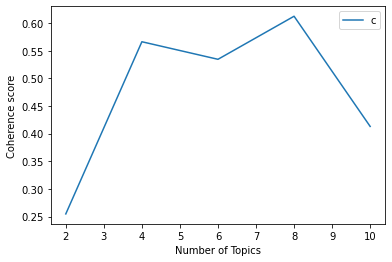

In [356]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Generating LDA Model with BoW implementation and saving the Model

In [357]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_bow_model = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2, random_state=100)

# save model to disk (no need to use pickle module)
lda_bow_model.save('lda_bow_model.model')

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_bow_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx + 1, topic))

Topic: 1 
Words: 0.010*"tannic" + 0.010*"rather" + 0.010*"herbal" + 0.010*"regular" + 0.010*"bottling" + 0.010*"wine" + 0.009*"companion" + 0.009*"think" + 0.009*"much" + 0.009*"come"

Topic: 2 
Words: 0.033*"acidity" + 0.033*"dried" + 0.023*"fruit" + 0.022*"fresh" + 0.022*"wine" + 0.022*"brisk" + 0.022*"fruity" + 0.022*"herb" + 0.022*"savory" + 0.022*"aroma"

Topic: 3 
Words: 0.007*"acidity" + 0.007*"flavor" + 0.007*"fruit" + 0.007*"wine" + 0.007*"fresh" + 0.007*"aroma" + 0.007*"balanced" + 0.007*"dried" + 0.007*"spice" + 0.007*"palate"

Topic: 4 
Words: 0.063*"flavor" + 0.042*"crisp" + 0.042*"acidity" + 0.023*"wine" + 0.023*"rind" + 0.023*"pineapple" + 0.023*"dominate" + 0.023*"green" + 0.023*"stainlesssteel" + 0.023*"underscoring"

Topic: 5 
Words: 0.025*"acidity" + 0.025*"fruit" + 0.025*"aroma" + 0.025*"fresh" + 0.025*"flavor" + 0.025*"herbal" + 0.025*"herb" + 0.025*"green" + 0.025*"finish" + 0.025*"mouth"

Topic: 6 
Words: 0.009*"informal" + 0.009*"berry" + 0.009*"open" + 0.009*"p

## Assign topic back to documents

In [358]:
df_sample_50_records['topics'] = [lda_bow_model.get_document_topics(dictionary.doc2bow(doc)) for doc in cleaned_text_list_split]

In [359]:
df_sample_50_records.head(2)

,country,description,cleaned_text,designation,points,ratings,ratings_label,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,topics
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",aroma include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity,Vulkà Bianco,87,good,2,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"[(1, 0.96022254)]"
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",ripe fruity wine smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better,Avidagos,87,good,2,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"[(1, 0.95832855)]"


# Create TF-IDF model object on bow_corpus and name it corpus_tfidf

In [360]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.03894657226774052),
 (1, 0.25142723998666694),
 (2, 0.1757400990236738),
 (3, 0.10005295806068072),
 (4, 0.25142723998666694),
 (5, 0.1757400990236738),
 (6, 0.25142723998666694),
 (7, 0.25142723998666694),
 (8, 0.3514801980473476),
 (9, 0.25142723998666694),
 (10, 0.10005295806068072),
 (11, 0.1314659597735267),
 (12, 0.25142723998666694),
 (13, 0.25142723998666694),
 (14, 0.25142723998666694),
 (15, 0.25142723998666694),
 (16, 0.1314659597735267),
 (17, 0.25142723998666694),
 (18, 0.25142723998666694),
 (19, 0.25142723998666694)]


# Choosing Optimal Number of Topics for LDA using TF-IDF

In [361]:
# Can take a long time to run. In this case we are going to  k_max=10
# import datetime
# print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    lda_tfidf_model= gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=lda_tfidf_model, texts=cleaned_text_list_split, dictionary=dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_tfidf_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

# print(datetime.datetime.now())

#Topics: 2 Score: 0.4039047490491644
#Topics: 4 Score: 0.5368096886711544
#Topics: 6 Score: 0.3414258546019773
#Topics: 8 Score: 0.35995733497142546
#Topics: 10 Score: 0.5472680385910093


## Plotting of Coherence Graph (TF-IDF BoW Implementation)

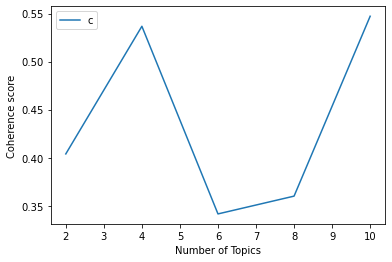

In [362]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## LDA using TF-IDF

In [363]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=2, random_state=100)

# save model to disk (no need to use pickle module)
lda_model_tfidf.save('lda_model_tfidf.model')

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.014*"balanced" + 0.014*"dry" + 0.014*"texture" + 0.014*"spice" + 0.012*"much" + 0.012*"apple" + 0.011*"profusion" + 0.011*"restrained" + 0.011*"food" + 0.011*"offer"

Topic: 2
Word: 0.013*"fruity" + 0.013*"note" + 0.011*"thyme" + 0.011*"sprightly" + 0.011*"offdry" + 0.011*"preserved" + 0.011*"elegant" + 0.011*"accent" + 0.011*"sunnier" + 0.011*"footprint"

Topic: 3
Word: 0.014*"lime" + 0.014*"poke" + 0.014*"flesh" + 0.014*"stainlesssteel" + 0.014*"underscoring" + 0.014*"dominate" + 0.014*"tart" + 0.014*"snappy" + 0.014*"fermented" + 0.012*"flavor"

Topic: 4
Word: 0.012*"typical" + 0.012*"blackberry" + 0.012*"grabby" + 0.012*"dark" + 0.012*"show" + 0.012*"horseradish" + 0.012*"whiff" + 0.012*"tomatoey" + 0.012*"complement" + 0.012*"plum"



# Performance evaluation by classifying sample document using LDA Bag of Words model

In [364]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9602225422859192	 
Topic: 0.033*"acidity" + 0.033*"dried" + 0.023*"fruit" + 0.022*"fresh" + 0.022*"wine" + 0.022*"brisk" + 0.022*"fruity" + 0.022*"herb" + 0.022*"savory" + 0.022*"aroma"


# Performance evaluation by classifying sample document using LDA TF-IDF model.

In [365]:
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.965425968170166	 
Topic: 0.014*"balanced" + 0.014*"dry" + 0.014*"texture" + 0.014*"spice" + 0.012*"much" + 0.012*"apple" + 0.011*"profusion" + 0.011*"restrained" + 0.011*"food" + 0.011*"offer"

Score: 0.011588984169065952	 
Topic: 0.013*"fruity" + 0.013*"note" + 0.011*"thyme" + 0.011*"sprightly" + 0.011*"offdry" + 0.011*"preserved" + 0.011*"elegant" + 0.011*"accent" + 0.011*"sunnier" + 0.011*"footprint"

Score: 0.011509068310260773	 
Topic: 0.012*"typical" + 0.012*"blackberry" + 0.012*"grabby" + 0.012*"dark" + 0.012*"show" + 0.012*"horseradish" + 0.012*"whiff" + 0.012*"tomatoey" + 0.012*"complement" + 0.012*"plum"

Score: 0.011476044543087482	 
Topic: 0.014*"lime" + 0.014*"poke" + 0.014*"flesh" + 0.014*"stainlesssteel" + 0.014*"underscoring" + 0.014*"dominate" + 0.014*"tart" + 0.014*"snappy" + 0.014*"fermented" + 0.012*"flavor"


In [366]:
unseen_document = "Delivering profound notes of black and red currants, blackberry fruit, blood orange citrus, and dried raspberries underscored by baking spices and dried red florals, this pinot noir is also a textural masterpiece with mouthwatering acidity and grippy cedar-like tannins"

unseen_document_list = [x for x in unseen_document.lower().split()]

bow_vector = dictionary.doc2bow((unseen_document_list))

for index, score in sorted(lda_model[bow_vector], key = lambda x: -1 * x[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6251998543739319	 Topic: 0.033*"acidity" + 0.033*"dried" + 0.023*"fruit" + 0.022*"fresh" + 0.022*"wine"
Score: 0.1505412757396698	 Topic: 0.025*"acidity" + 0.025*"fruit" + 0.025*"aroma" + 0.025*"fresh" + 0.025*"flavor"
Score: 0.1461242437362671	 Topic: 0.028*"much" + 0.028*"wine" + 0.015*"note" + 0.015*"orange" + 0.015*"finish"
Score: 0.015632156282663345	 Topic: 0.063*"flavor" + 0.042*"crisp" + 0.042*"acidity" + 0.023*"wine" + 0.023*"rind"
Score: 0.015625659376382828	 Topic: 0.009*"informal" + 0.009*"berry" + 0.009*"open" + 0.009*"pepper" + 0.009*"soft"
Score: 0.0156256053596735	 Topic: 0.007*"acidity" + 0.007*"flavor" + 0.007*"fruit" + 0.007*"wine" + 0.007*"fresh"
Score: 0.0156256053596735	 Topic: 0.007*"acidity" + 0.007*"wine" + 0.007*"fruit" + 0.007*"fresh" + 0.007*"balanced"
Score: 0.015625599771738052	 Topic: 0.010*"tannic" + 0.010*"rather" + 0.010*"herbal" + 0.010*"regular" + 0.010*"bottling"


# Testing the saved Model (BoW TF-IDF Implementation)

In [367]:
# later on, load trained model from file
model =  models.LdaModel.load('lda_model_tfidf.model')

# Print Number of topics 
print(model.num_topics)

# print all topics
model.show_topics()

4


[(0,
  '0.014*"balanced" + 0.014*"dry" + 0.014*"texture" + 0.014*"spice" + 0.012*"much" + 0.012*"apple" + 0.011*"profusion" + 0.011*"restrained" + 0.011*"food" + 0.011*"offer"'),
 (1,
  '0.013*"fruity" + 0.013*"note" + 0.011*"thyme" + 0.011*"sprightly" + 0.011*"offdry" + 0.011*"preserved" + 0.011*"elegant" + 0.011*"accent" + 0.011*"sunnier" + 0.011*"footprint"'),
 (2,
  '0.014*"lime" + 0.014*"poke" + 0.014*"flesh" + 0.014*"stainlesssteel" + 0.014*"underscoring" + 0.014*"dominate" + 0.014*"tart" + 0.014*"snappy" + 0.014*"fermented" + 0.012*"flavor"'),
 (3,
  '0.012*"typical" + 0.012*"blackberry" + 0.012*"grabby" + 0.012*"dark" + 0.012*"show" + 0.012*"horseradish" + 0.012*"whiff" + 0.012*"tomatoey" + 0.012*"complement" + 0.012*"plum"')]

In [368]:
unseen_document = "Delivering profound notes of black and red currants, blackberry fruit, blood orange citrus, and dried raspberries underscored by baking spices and dried red florals, this pinot noir is also a textural masterpiece with mouthwatering acidity and grippy cedar-like tannins"

unseen_document_list = [x for x in unseen_document.lower().split()]

bow_vector = dictionary.doc2bow((unseen_document_list))

for index, score in sorted(model[bow_vector], key = lambda x: -1 * x[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5101406574249268	 Topic: 0.010*"tannic" + 0.010*"rather" + 0.010*"herbal" + 0.010*"regular" + 0.010*"bottling"
Score: 0.4189194142818451	 Topic: 0.033*"acidity" + 0.033*"dried" + 0.023*"fruit" + 0.022*"fresh" + 0.022*"wine"
Score: 0.03882918879389763	 Topic: 0.063*"flavor" + 0.042*"crisp" + 0.042*"acidity" + 0.023*"wine" + 0.023*"rind"
Score: 0.032110750675201416	 Topic: 0.007*"acidity" + 0.007*"flavor" + 0.007*"fruit" + 0.007*"wine" + 0.007*"fresh"
